Purpose of this notebook is to create a model that can predict credit card fraud 

Data Source: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

### Imports 

In [1]:
# data
import pandas as pd 
import numpy as np 

# visuals 
import matplotlib.pyplot as plt
import seaborn as sns
from helper_functions import *


# modeling 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier

# imbalance  
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# hyperparameter tunning 
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from functools import partial

# performance 
from sklearn.metrics import *
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Data

In [18]:
df = pd.read_parquet('creditcard.parquet')

In [19]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Data Processing 

##### Spliting Data 

In [4]:
X, y = df.drop('Class', axis = 1), df['Class']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = 0.10, random_state=42)

X_test_valid = pd.concat([X_test, X_valid], axis = 0)
y_test_valid = pd.DataFrame(pd.concat([y_test, y_valid], axis = 0), columns=['Class'])

y_test = pd.DataFrame(y_test)
y_valid = pd.DataFrame(y_valid)

##### Imbalance Problem 

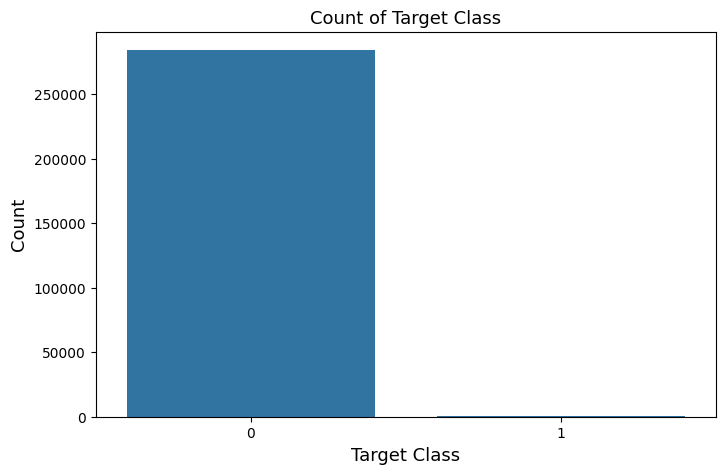

target class dist
 Class
0    284315
1       492
Name: count, dtype: int64
target class dist %
 Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


In [179]:
plt.figure(figsize=(8,5))
ax = sns.countplot(x = 'Class', data = df)
plt.title('Count of Target Class', fontsize=13)
plt.xlabel('Target Class', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.show()

print(f'target class dist\n {df.Class.value_counts()}')
print(f'target class dist %\n {df.Class.value_counts(normalize = True)*100}')

In [180]:
over_smote = SMOTE(sampling_strategy = 0.10, random_state = 42)
under = RandomUnderSampler(sampling_strategy = 0.50, random_state = 42)

steps = [('over', over_smote), ('under', under)]
pipeline = Pipeline(steps=steps)

X_train_res, y_train_res = pipeline.fit_resample(X_train, y_train)

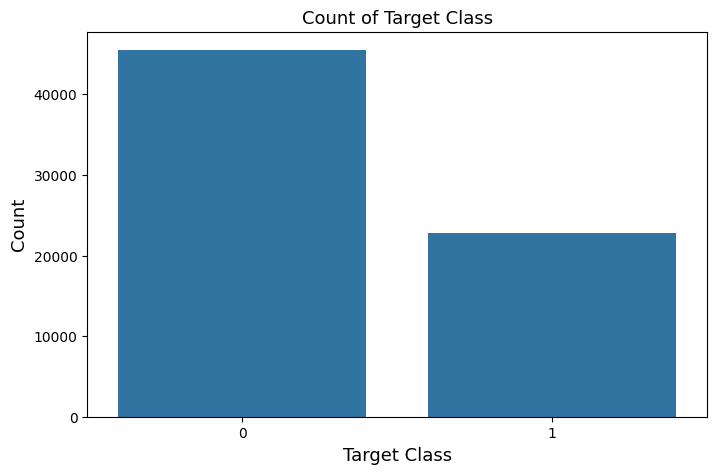

target class dist
 Class
0    45490
1    22745
Name: count, dtype: int64
target class dist %
 Class
0    66.666667
1    33.333333
Name: proportion, dtype: float64


In [181]:
plt.figure(figsize=(8,5))
ax = sns.countplot(data = pd.DataFrame(y_train_res), x = 'Class')
plt.title('Count of Target Class', fontsize=13)
plt.xlabel('Target Class', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.show()

print(f'target class dist\n {y_train_res.value_counts()}')
print(f'target class dist %\n {y_train_res.value_counts(normalize = True)*100}')

### Models  

##### Logistic Regression

In [182]:
log_c = LogisticRegression(random_state=42, max_iter= 200)
log_c.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=200, random_state=42)

In [183]:
y_test_valid['log_pred'] = log_c.predict(X_test_valid)

y_test_valid['log_proba'] = log_c.predict_proba(X_test_valid)[:,1]

f1_score: 0.1881
precision_score: 0.1052
recall_score: 0.8878
accuracy_score: 0.9868


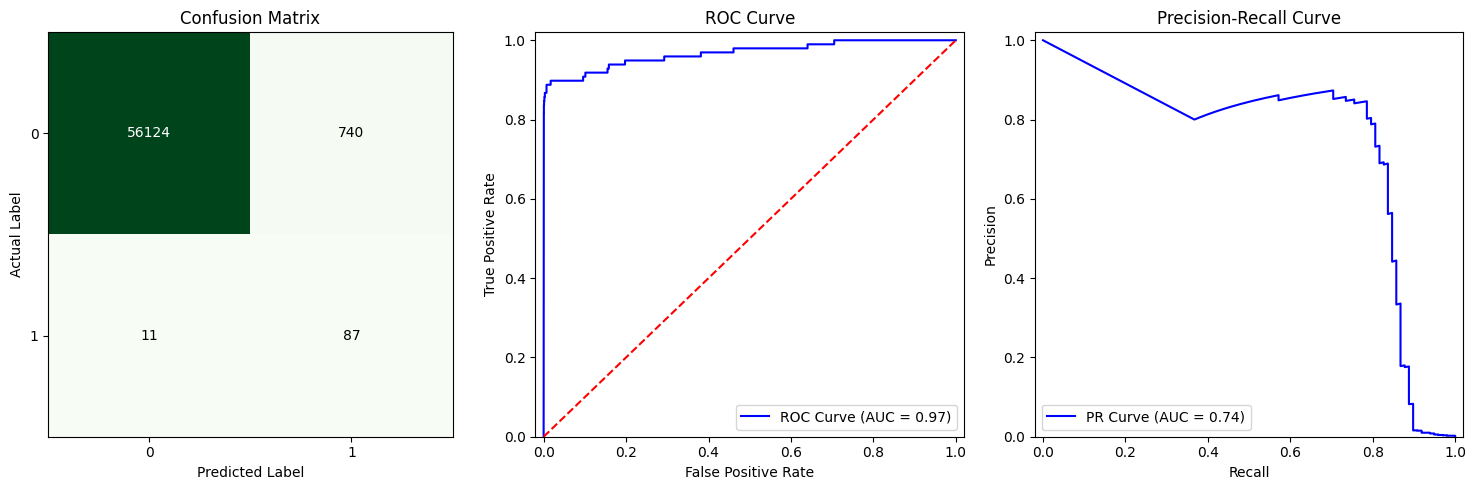

In [184]:
classification_metrics(y_test_valid['Class'], y_test_valid['log_pred'])

performance_eval(y_test_valid['Class'], y_test_valid['log_pred'], y_test_valid['log_proba'])

##### XGBoost + Hyperopt

In [6]:
def objective_function_xgb(
    search_space
    , x_train, y_train
    , x_valid, y_valid):
    '''
    Hyperopt objective function for hyperparameter tunning 
    '''
    pos_count = y_train.sum()
    neg_count = len(y_train) - pos_count
    imbalance_ratio = neg_count / pos_count

    model_train = XGBClassifier(**search_space, scale_pos_weight=imbalance_ratio, random_state = 42)
    model_train.fit(x_train, y_train)

    pred = model_train.predict(x_valid)

    valid_f1 = precision_score(y_valid['Class'], pred)
    print("Score", valid_f1)

    return {'loss': -valid_f1, 'status': STATUS_OK, 'model': model_train}


search_space = {
    'max_depth': scope.int(hp.quniform("max_depth", 3, 15, 1))
    , 'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2))
    , 'gamma': hp.uniform('gamma', 0.0001, 10)
    , 'reg_alpha': hp.quniform('reg_alpha', 0, 5, 1)
    , 'reg_lambda': hp.uniform('reg_lambda', 0, 5)
    , 'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1)
    , 'min_child_weight': hp.quniform('min_child_weight', 1, 20, 1)
    , 'n_estimators': scope.int(hp.quniform('n_estimators', 20, 80, 1)) 
}

In [7]:
trials = Trials()

xgb_fmin_objective = partial(
    objective_function_xgb
    , x_train = X_train, y_train = y_train
    , x_valid = X_valid, y_valid = y_valid
)

In [8]:
best_xgb = fmin(
    fn = xgb_fmin_objective
    , space = search_space
    , algo = tpe.suggest
    , max_evals = 100
    , trials = trials 
    , rstate = np.random.default_rng(42)
) 

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

Score                                                  
0.79                                                   
Score                                                               
0.85                                                                
Score                                                               
0.8404255319148937                                                  
Score                                                               
0.18949771689497716                                                 
Score                                                               
0.32489451476793246                                                 
Score                                                               
0.7090909090909091                                                  
Score                                                               
0.8210526315789474                                                  
Score                                                       

In [9]:
best_xgb

{'colsample_bytree': 0.23821079146666568,
 'gamma': 0.6625237341901664,
 'learning_rate': 0.02781091684203207,
 'max_depth': 13.0,
 'min_child_weight': 2.0,
 'n_estimators': 41.0,
 'reg_alpha': 1.0,
 'reg_lambda': 3.1363175437440862}

In [10]:
tunned_xgb_model = sorted(trials.results, 
    key = lambda results: results['loss'])[0]['model']

In [11]:
y_test['xgb_pred'] = tunned_xgb_model.predict(X_test)

y_test['xgb_proba'] = tunned_xgb_model.predict_proba(X_test)[:, 1]

f1_score: 0.8333
precision_score: 0.8333
recall_score: 0.8333
accuracy_score: 0.9996


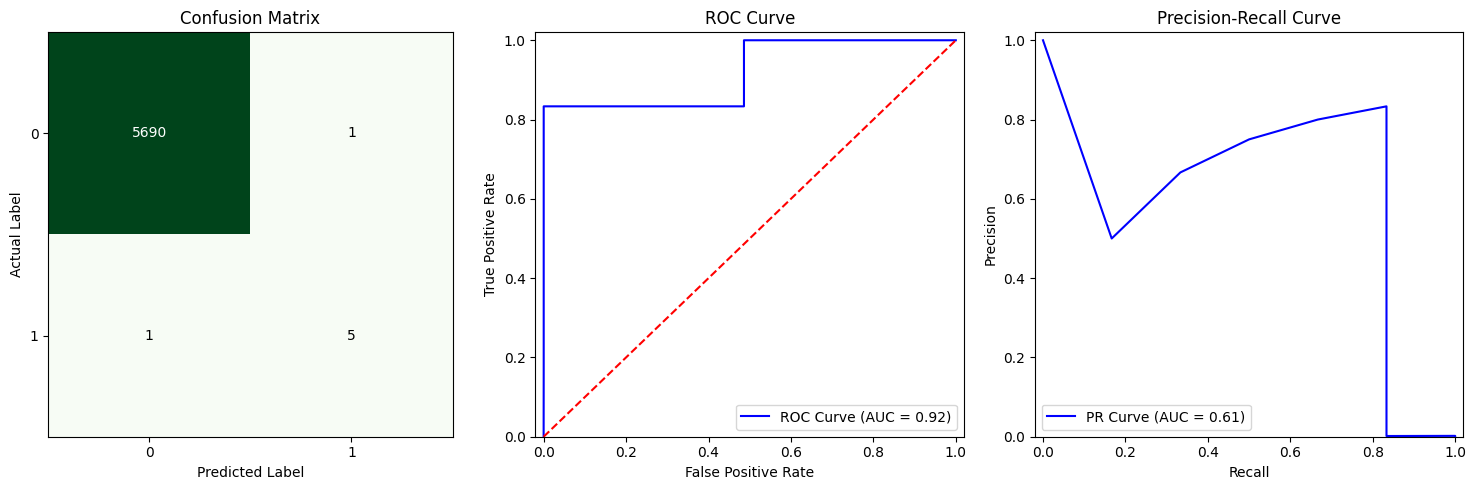

In [12]:
classification_metrics(y_test['Class'], y_test['xgb_pred'])

performance_eval(y_test['Class'], y_test['xgb_pred'], y_test['xgb_proba'])

##### Error Analysis 

In [170]:
pred_combine = pd.concat([X_test, y_test], axis = 1)

pred_combine['error'] = np.where(pred_combine['Class'] != pred_combine['xgb_pred'], 1, 0)


divide by zero encountered in log


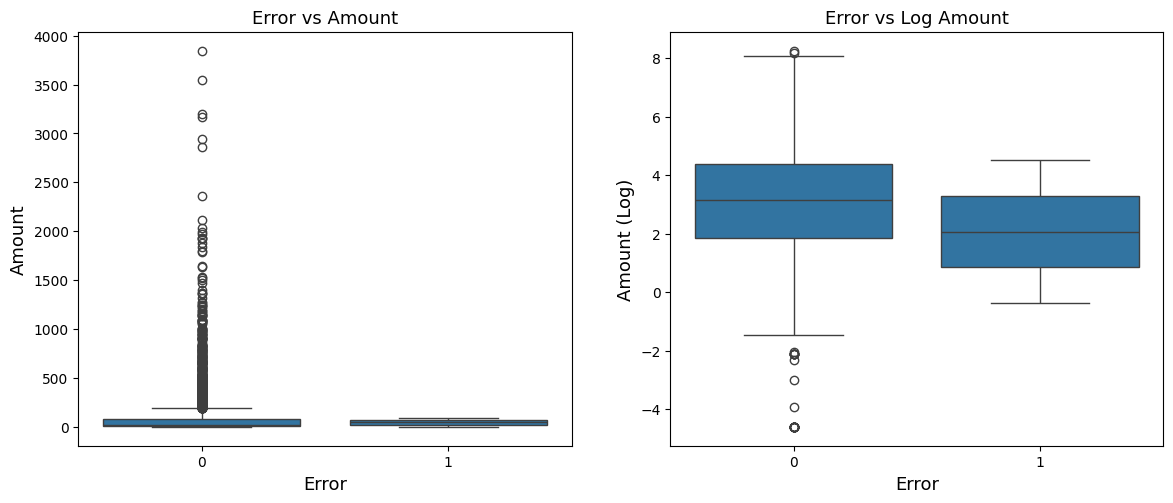

In [171]:
plt.figure(figsize=(14,6))
plt.subplot(121)
ax = sns.boxplot(x = "error",y= "Amount", data = pred_combine)
ax.set_title("Error vs Amount", fontsize=13)
ax.set_xlabel("Error", fontsize=13)
ax.set_ylabel("Amount", fontsize = 13)

plt.subplot(122)
ax1 = sns.boxplot(x = pred_combine.error,y = np.log(pred_combine.Amount))
ax1.set_title("Error vs Log Amount", fontsize=13)
ax1.set_xlabel("Error", fontsize=13)
ax1.set_ylabel("Amount (Log)", fontsize = 13)

plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()

In [172]:
timedelta = pd.to_timedelta(pred_combine['Time'], unit='s')
pred_combine['Time_Min'] = (timedelta.dt.components.minutes).astype(int)
pred_combine['Time_Hour'] = (timedelta.dt.components.hours).astype(int)

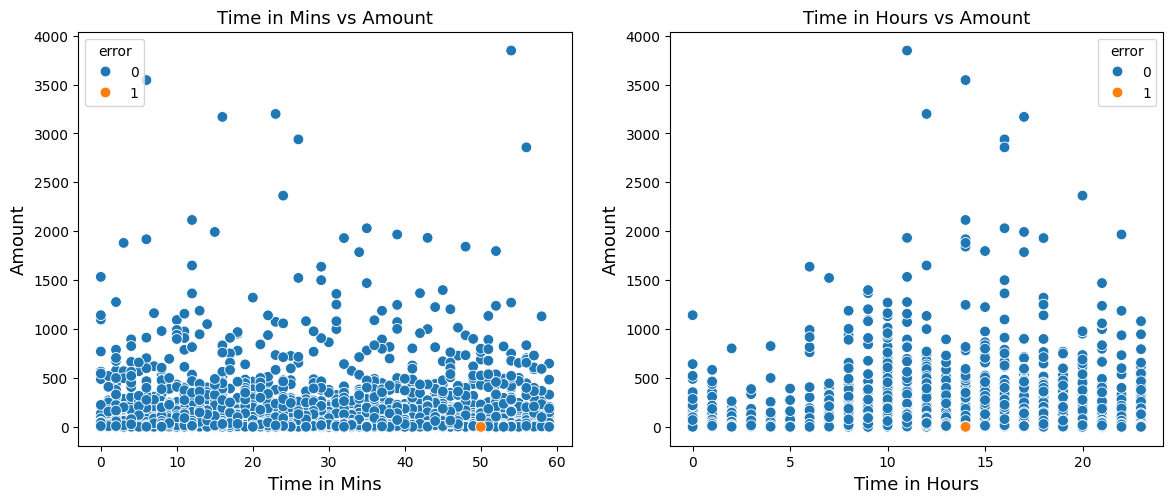

In [173]:
plt.figure(figsize=(14,6))
plt.subplot(121)
ax = sns.scatterplot(y = "Amount", x = "Time_Min", data = pred_combine.sort_values('Class'), hue = 'error', s = 60)
ax.set_title("Time in Mins vs Amount", fontsize=13)
ax.set_xlabel("Time in Mins", fontsize=13)
ax.set_ylabel("Amount", fontsize = 13)

plt.subplot(122)
ax1 = sns.scatterplot(y = "Amount", x = "Time_Hour", data = pred_combine.sort_values('Class'), hue = 'error', s = 60)
ax1.set_title("Time in Hours vs Amount", fontsize=13)
ax1.set_xlabel("Time in Hours", fontsize=13)
ax1.set_ylabel("Amount", fontsize = 13)

plt.subplots_adjust(hspace = 0.6, top = 0.8)